# Testing One-Point GEV Distribution

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import pycic.distributions as dist

## Cosmology Object

Instantces of class `cosmology` store parameters for a flat $\Lambda$-CDM cosmology. This class also defines the functions like $E(z)$, the growth factor etc. Growth factor is computed by the approximate form given by Carroll et al (1992). Default power spectrum model is the Eisenstein-Hu no BAO model.

Working cosmology model: $H_0 = 70$ km/s/Mpc, $\Omega_m = 0.3$, $\Omega_b = 0.05$ and $\Omega_{de} = 0.7$. 

In [2]:
c = dist.Cosmology(Om0 = 0.3, Ob0 = 0.05, h = 0.7, ns = 1, sigma8 = 0.8)
print(c)

Cosmology(Om0=0.3, Ob0=0.05, Ode0=0.7, Onu0=0, h=0.7, Tcmb0=2.725K, ns=1, sigma8=0.8)


In [3]:
def drawCosmologyFunction(c: dist.Cosmology, z: np.ndarray):
    """ draw cosmology functions. """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 6), )

    ax1.plot(z, c.Omz(z), label = 'matter')
    ax1.plot(z, c.Odez(z), label = 'dark-energy')
    ax1.set(xlabel = 'z', ylabel = '$\\Omega_i$(z)')
    ax1.legend(
                    bbox_to_anchor = (0., 1.02, 1., 0.102), 
                    loc  = 'lower left',
                    ncol = 2, mode = 'expand', borderaxespad = 0,
               )

    ax2.plot(z, c.Dz(z), label = 'growth factor, D(z)')
    ax2.plot(z, c.fz(z), label = 'growth rate, f(z)')
    ax2.set(xlabel = 'z', ylabel = 'D(z) or f(z)')
    ax2.legend(
                    bbox_to_anchor = (0., 1.02, 1., 0.102), 
                    loc  = 'lower left',
                    ncol = 2, mode = 'expand', borderaxespad = 0,
               )
    
    plt.show()

def drawPowerVariance(c: dist.Cosmology, k: np.ndarray, r: np.ndarray, z: np.ndarray):
    """ draw the power spectrum and variance. """
    # create a colormap
    from matplotlib import colors, cm 
    cmap = cm.ScalarMappable(
                                norm = colors.Normalize(z.min(), z.max()),
                                cmap = cm.Reds_r
                            )
    cmap.set_array([])

    fig, (ax1, ax2, cax) = plt.subplots(1, 3, figsize = (16, 6), gridspec_kw = {"width_ratios": [1, 1, 0.05]}, )
    ax1.loglog(); ax2.loglog()

    for zi in z:
        ax1.plot(k, c.matterPowerSpectrum(k, zi), '-', color = cmap.to_rgba(zi), )
        ax2.plot(k, c.variance(r, zi), '-', color = cmap.to_rgba(zi), )

    ax1.set(xlabel = 'k', ylabel = 'P(k)')
    ax2.set(xlabel = 'r', ylabel = '$\\sigma^2$(r)')

    plt.colorbar(cmap, cax = cax, orientation = 'vertical')
    cax.set(ylabel = 'redshift')

    plt.show()

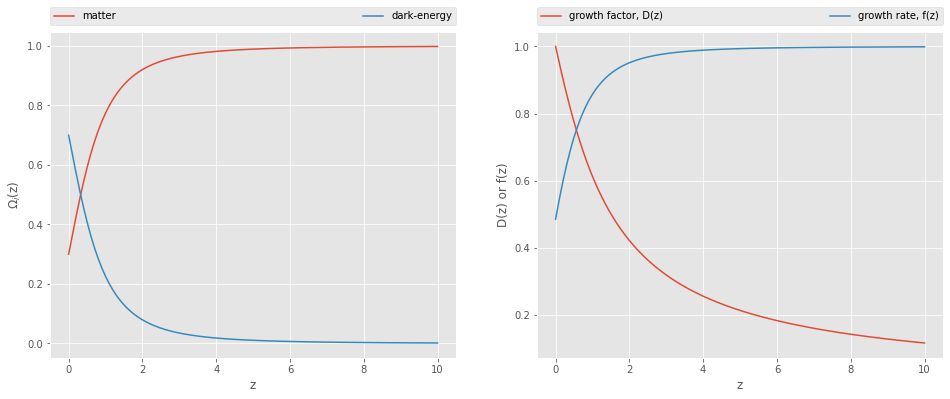

In [4]:
# draw densities and linear growth factors:
drawCosmologyFunction(c, z = np.mgrid[0:10:201j],)

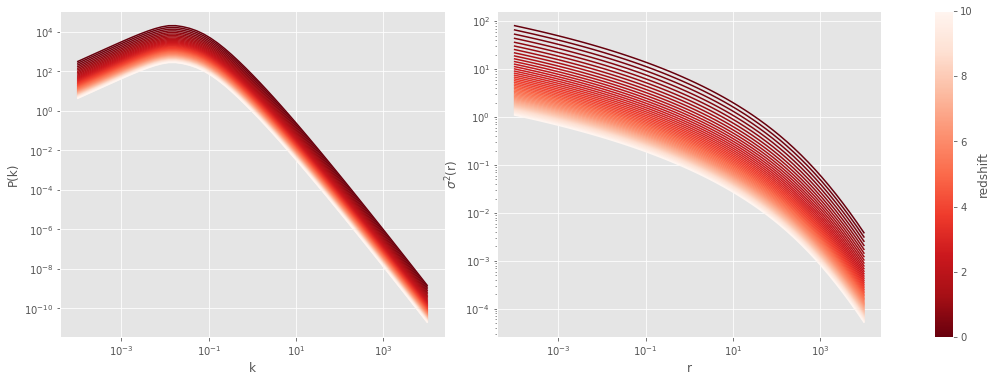

sigma(8 Mpc/h) =  0.8


In [5]:
# draw normalised power spectrum and variances:
drawPowerVariance(c, k = np.logspace(-4, 4, 51), r = np.logspace(-2, 2, 51), z = np.mgrid[0:10:51j],)

print("sigma(8 Mpc/h) = ", c.variance(8)**0.5)

## One-Point GEV Distribution

In [3]:
# distribution at redshift 0
d = dist.GEVDistribution(1.95, c, 0)

### Variances

Variances needed for 1-point distribution function calculations are:

#### 1. Linear variance in the cell

For a cubic cell of sidelength $l$, linear variance of the density fluctuations is given by 

$$ \sigma_{\rm lin}^2 (k_N) = \frac{1}{2\pi^2} \int_0^{k_N} k^2 P_{\rm lin}(k) {\rm d}k $$

where $k_N = l / \pi$ is the Nyquist wavenumber.


In [7]:
vlin = d.linearCellVariance()
vlin

5.401189201640844


#### 2. Variance of the Log Field

For the log field $A = \log(1+\delta)$, variance is given in terms of the linear variance through the fit

$$ \sigma^2_A (k_N) = \mu \log \left( 1 + \frac{\sigma^2_{\rm lin}(k_N)}{\mu} \right) $$

with the best-fit value, $\mu = 0.73$.


In [8]:
vlog = d.logCellVariance(vlin)
vlog

1.5535126152738423

### Log Field Bias

For the log field, the power spectrum is related to the linear power through a bias, $b_A$ as 

$$ P_A(k) = b_A^2 P_{\rm lin}(k) $$

In [9]:
np.sqrt(vlog / vlin) # bias

0.5363060507056775

### Measured Power Spectrum and CIC Variance

Count-in-cell introduces a convolution of over-density signal with real-space cubical top-hat filter. This introduce a factor of $W^2(k)$ in the variance equation. This factor is given by the mass assignment function

$$ W({\bf k}) = \prod_{i=x,y,z} {\rm sinc}^p \left( \frac{k_i}{2 k_n} \right) $$

where ${\rm sinc}(x) = \sin(\pi x) / (\pi x)$ is the normalised 'sinc' function and $p=1$ is correspond to NGC mass assignment. 

The measured power spectrum is then given as

$$ P_{A, \rm meas}({\bf k}) = \sum_{{\bf n} \in \Z^3} P_A({\bf k} + 2k_N{\bf n}) W^2({\bf k} + 2k_N{\bf n}) $$

where $\vert {\bf n} \vert < 3$ and this equation is valid when $\vert {\bf k} \vert \le k_N$. After that, a power law continuation of the form $P_{A, \rm meas}({\bf k}) = a \vert {\bf k} \vert^b $ is used to get the power.


Measured CIC variance is given by the integral

$$ \sigma_A^2(l) = \int_{V} \frac{{\rm d}^3 k}{(2 \pi)^3} P_{A, \rm meas} ({\bf k}) $$

where $V$ is the region of integration, which is the cube with sides from $-k_N$ to $k_N$, excluding the zero vector.

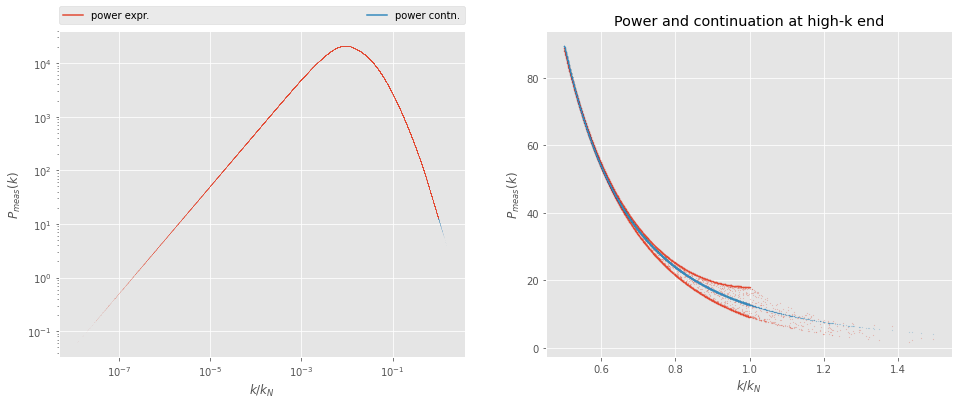

In [10]:
def drawMeasuredPower(d: dist.GEVDistribution, n: int):
    """ draw the measured power as function of k """
    # generate some random k vectors inside the cube:
    logkn      = np.log10(d.kn)
    kx, ky, kz = 10**np.random.uniform(-8, logkn, (3, n)) * np.random.choice([-1, 1], (3, n))

    k = np.sqrt(kx**2 + ky**2 + kz**2)

    pk     = d.measuredPowerSpectrum(kx, ky, kz)
    pk_in  = d._measuredPowerInsideSphere(kx, ky, kz) * d.cosmo._pknorm
    pk_out = d._measuredPowerOutsideSphere(k) * d.cosmo._pknorm

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 6))

    ax1.loglog()

    mask = (k <= d.kn)
    ax1.plot([], [], '-', color = 'C0', label = 'power expr.')
    ax1.plot([], [], '-', color = 'C1', label = 'power contn.')
    ax1.plot(k[ mask]/d.kn, pk[mask], 'o', ms = 0.01, color = 'C0')
    ax1.plot(k[~mask]/d.kn, pk[~mask], 'o', ms = 0.01, color = 'C1')
    ax1.set(xlabel = '$k/k_N$', ylabel = '$P_{meas}(k)$')
    ax1.legend(
                bbox_to_anchor =(0., 1.02, 1., 0.102), 
                loc  = 'lower left',
                ncol = 2, mode = 'expand', borderaxespad = 0, 
              )

    # draw the large k end:
    mask = (k > d.kn * 0.5)
    ax2.plot(k[mask]/d.kn, pk_in [mask], 'o', ms = 0.1, color = 'C0', ) 
    ax2.plot(k[mask]/d.kn, pk_out[mask], 'o', ms = 0.1, color = 'C1', ) 
    ax2.set(xlabel = '$k/k_N$', ylabel = '$P_{meas}(k)$')
    ax2.set_title("Power and continuation at high-k end")

    plt.show()

drawMeasuredPower(d, 100_000)

In [11]:
vcic = d.measuredVariance() * vlog / vlin
print("measured cic varaince = ", vcic)

measured cic varaince =  1.4083297529358265


### Distribution Function for Log-Field

One point distribution for the log field, $A$ is 

$$ P(\delta) = \frac{1}{\sigma} t^{(1 + \xi)} e^{-t} $$

where

$$ t = \left( 1 + \frac{A - \mu}{\sigma} \right)^{-1/\xi} $$

where $\mu, \sigma, \xi$ are the location, scale, shape parameters.

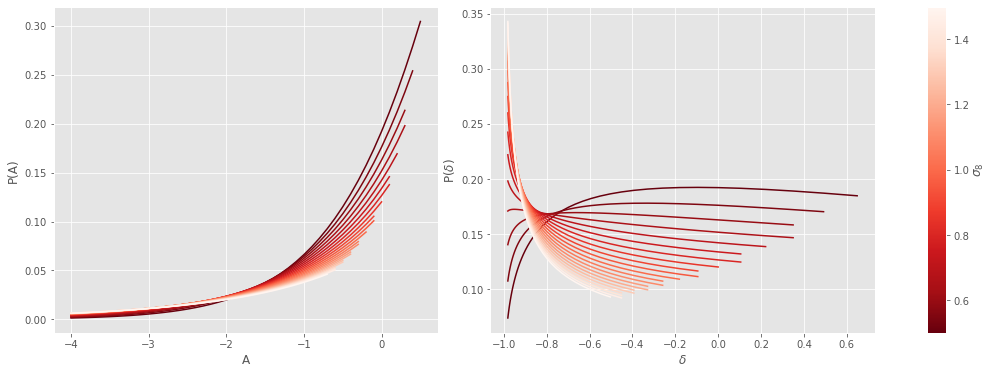

In [5]:
def drawDistributionFunction(d: dist.GEVDistribution, a: np.ndarray, s8: np.ndarray):
    """ draw the distribution function as function of sigma8 """
    from matplotlib import colors, cm 
    cmap = cm.ScalarMappable(
                                norm = colors.Normalize(s8.min(), s8.max()),
                                cmap = cm.Reds_r
                            )
    cmap.set_array([])

    delta = np.exp(a)-1 # delta

    fig, (ax1, ax2, cax) = plt.subplots(1, 3, figsize = (16, 6), gridspec_kw = {"width_ratios": [1, 1, 0.05]}, )

    for sigma8 in s8:
        d.parametrize(sigma8, 1.0) # parametrise the pdf
        fa = d.onepdf(a, log = True)       # a is ln(1+delta)
        fd = d.onepdf(delta)

        mask = (fa > 0.0)
        ax1.plot(a[mask], fa[mask], '-', color = cmap.to_rgba(sigma8), )
        ax2.plot(delta[mask], fd[mask], '-', color = cmap.to_rgba(sigma8), )

    ax1.set(xlabel = 'A', ylabel = 'P(A)')
    ax2.set(xlabel = '$\\delta$', ylabel = 'P($\\delta$)')

    plt.colorbar(cmap, cax = cax, orientation = 'vertical')
    cax.set(ylabel = '$\\sigma_8$')

    plt.plot()

drawDistributionFunction(d, a = np.mgrid[-4:1:51j], s8 = np.mgrid[0.5:1.5:21j])

### Notes

With cellsize $l = 1.95$ Mpc/h, and using a deconvolved and anti-aliased power, $P_A(k)$, log field variance is given by $\sigma_A^2(k_N) = 1.18$ (unknown power spectrum type and parameters). This corresponds to the linear variance of $2.94$. Also, the measured count-in-cells variance is $\sigma_A^2(l) = 1.49$.

In [13]:
def invert_vlog(vlog: float, mu: float = 0.73):
    """ invert log field varaince to get linear variance. """
    return (np.exp(vlog / mu) - 1) * mu

print("lin-var = 1.18 --> log-var =", invert_vlog(1.18))

# values got:
print("lin-var = {}, log-var = {}, cic-var = {}".format(vlin, vlog, vcic)) 

lin-var = 1.18 --> log-var = 2.945641265016975
lin-var = 5.401189201640844, log-var = 1.5535126152738423, cic-var = 1.4083297529358265


# Count-in-Cells Distribution

Given a one point distribution $P(\delta)$, the count-in-cells distribution is given by 

$$ P(N) = \int {\rm d}\delta P(\delta) P(N \vert \delta) $$

and a distribution for the count, $P(N \vert \delta)$, can be taken as a Poisson distribution. i.e.,

$$ P(N \vert \delta) = \frac{\mu^N e^{-\mu}}{N!} $$

where $\mu = \bar{N} (b\delta + 1)$ is the expected count at given density value and bias.

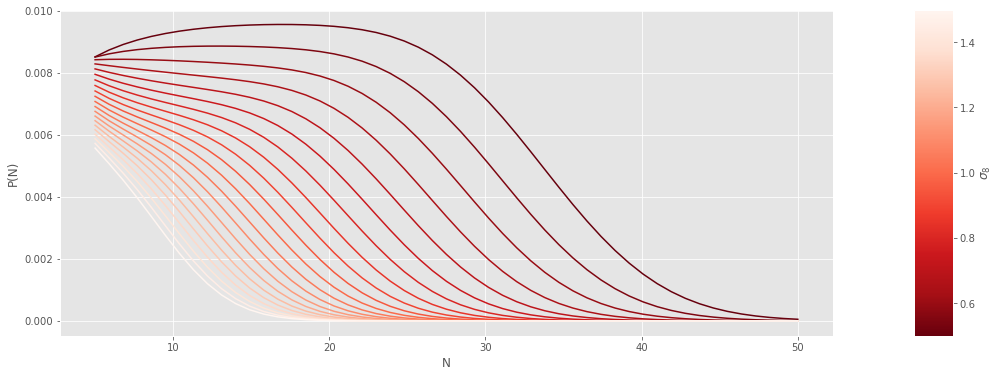

In [7]:
def drawDistributionFunction_cic(d: dist.GEVDistribution, n: np.ndarray, s8: np.ndarray, nbar: float, b: float):
    """ draw the cic distribution """
    from matplotlib import colors, cm 
    cmap = cm.ScalarMappable(
                                norm = colors.Normalize(s8.min(), s8.max()),
                                cmap = cm.Reds_r
                            )
    cmap.set_array([])

    fig, (ax1, cax) = plt.subplots(1, 2, figsize = (16, 6), gridspec_kw = {"width_ratios": [1, 0.05]}, )

    for sigma8 in s8:
        d.parametrize(sigma8 = sigma8, bias = b) # parametrise the pdf
        f = d.cicpdf(n, nbar)       # a is ln(1+delta)

        ax1.plot(n, f, '-', color = cmap.to_rgba(sigma8), )

    ax1.set(xlabel = 'N', ylabel = 'P(N)')

    plt.colorbar(cmap, cax = cax, orientation = 'vertical')
    cax.set(ylabel = '$\\sigma_8$')

    plt.plot()

drawDistributionFunction_cic(d, np.mgrid[5:50:51j], np.mgrid[0.5:1.5:21j], 20, 1.0)